In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Download dataset

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


68606236/68606236 [==============================] - 2s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 1000 files belonging to 2 classes.


In [5]:
path_to_zip

'/root/.keras/datasets/cats_and_dogs.zip'

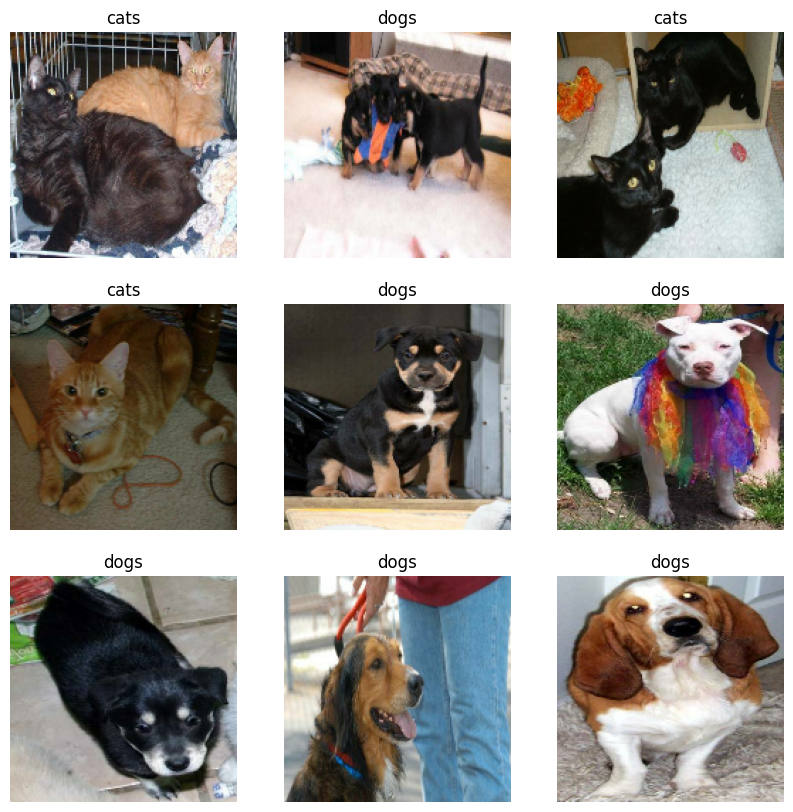

In [6]:
# Show thr first nine images and labels from training images
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 26
Number of test batches: 6


# Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [12]:
# use data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


# Create base model from pretrained convnets

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9406464/9406464 [==============================] - 1s 0us/step


This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [16]:
#freeze the convolutional base
base_model.trainable=False

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [18]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [19]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


#Compile the model

In [25]:
base_learning_rate = 0.0001
history=model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])


Train the model

In [22]:
model.fit(train_dataset,epochs=10,validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 12s 85ms/step - loss: 0.7338 - accuracy: 0.5655 - val_loss: 0.5545 - val_accuracy: 0.7401
Epoch 2/10
63/63 [==============================] - 5s 69ms/step - loss: 0.5378 - accuracy: 0.7360 - val_loss: 0.4075 - val_accuracy: 0.8490
Epoch 3/10
63/63 [==============================] - 4s 54ms/step - loss: 0.4372 - accuracy: 0.8180 - val_loss: 0.3107 - val_accuracy: 0.9171
Epoch 4/10
63/63 [==============================] - 3s 52ms/step - loss: 0.3752 - accuracy: 0.8490 - val_loss: 0.2482 - val_accuracy: 0.9468
Epoch 5/10
63/63 [==============================] - 5s 70ms/step - loss: 0.3144 - accuracy: 0.8880 - val_loss: 0.2156 - val_accuracy: 0.9480
Epoch 6/10
63/63 [==============================] - 4s 61ms/step - loss: 0.2934 - accuracy: 0.8850 - val_loss: 0.1895 - val_accuracy: 0.9579
Epoch 7/10
63/63 [==============================] - 5s 78ms/step - loss: 0.2643 - accuracy: 0.8985 - val_loss: 0.1688 - val_accuracy: 0.9641
Epoch 8/10
6

In [23]:
loss,accuracy=model.evaluate(validation_dataset)

26/26 [==============================] - 3s 67ms/step - loss: 0.1252 - accuracy: 0.9740
